In [1]:
from typing import Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm



sns.set_style('whitegrid')
template = 'seaborn'

2024-05-04 17:46:18.670409: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 17:46:18.734497: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 17:46:18.734524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 17:46:18.734539: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 17:46:18.750223: I tensorflow/core/platform/cpu_feature_g

In [2]:
BASE_PATH = './'

In [3]:
size = (168, 168)

In [4]:
train = pd.read_csv(f'{BASE_PATH}/training_data.csv', sep=";")
test = pd.read_csv(f'{BASE_PATH}/testing_data.csv', sep=";")

In [5]:
num_classes = len(train['class'].unique())
num_classes

4

In [6]:
def preprocessing_image(path: str, shape: Tuple[int, int], normalize: bool = False) -> np.ndarray:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if shape:
        image = cv2.resize(image, shape)
    if normalize:
        image = image/255
    return image

In [7]:
images = [preprocessing_image(f"{BASE_PATH}/{image}", size, normalize=True) for image in train['path']]
labels = [label for label in train['class']]

In [8]:
images = np.array(images)
labels = np.array(labels)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, shuffle=True)

In [10]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomBrightness(0.1),
])

2024-05-04 17:46:29.397279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 17:46:29.555078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 17:46:29.555136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 17:46:29.556680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 17:46:29.556716: I tensorflow/compile

In [11]:
model = keras.Sequential([
    # data_augmentation,

    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),    
    keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
history = model.fit(
                    x=X_train,
                    y=y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=16
                  )

Epoch 1/20


2024-05-04 17:46:39.357978: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-04 17:46:39.571424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-05-04 17:46:39.744786: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-04 17:46:40.447985: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-04 17:46:40.826567: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd4f9a3b420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-04 17:46:40.826590: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute

286/286 [==============================] - 9s 13ms/step - loss: 0.6608 - accuracy: 0.7452 - val_loss: 1.5569 - val_accuracy: 0.3885
Epoch 2/20
286/286 [==============================] - 3s 9ms/step - loss: 0.3496 - accuracy: 0.8709 - val_loss: 0.3932 - val_accuracy: 0.8539
Epoch 3/20
286/286 [==============================] - 3s 9ms/step - loss: 0.2245 - accuracy: 0.9223 - val_loss: 0.2665 - val_accuracy: 0.8994
Epoch 4/20
286/286 [==============================] - 3s 9ms/step - loss: 0.1586 - accuracy: 0.9512 - val_loss: 0.2390 - val_accuracy: 0.9038
Epoch 5/20
286/286 [==============================] - 3s 9ms/step - loss: 0.1176 - accuracy: 0.9626 - val_loss: 0.2285 - val_accuracy: 0.9213
Epoch 6/20
286/286 [==============================] - 3s 9ms/step - loss: 0.0715 - accuracy: 0.9829 - val_loss: 0.1995 - val_accuracy: 0.9248
Epoch 7/20
286/286 [==============================] - 3s 9ms/step - loss: 0.0580 - accuracy: 0.9862 - val_loss: 0.2215 - val_accuracy: 0.9178
Epoch 8/20
286/2

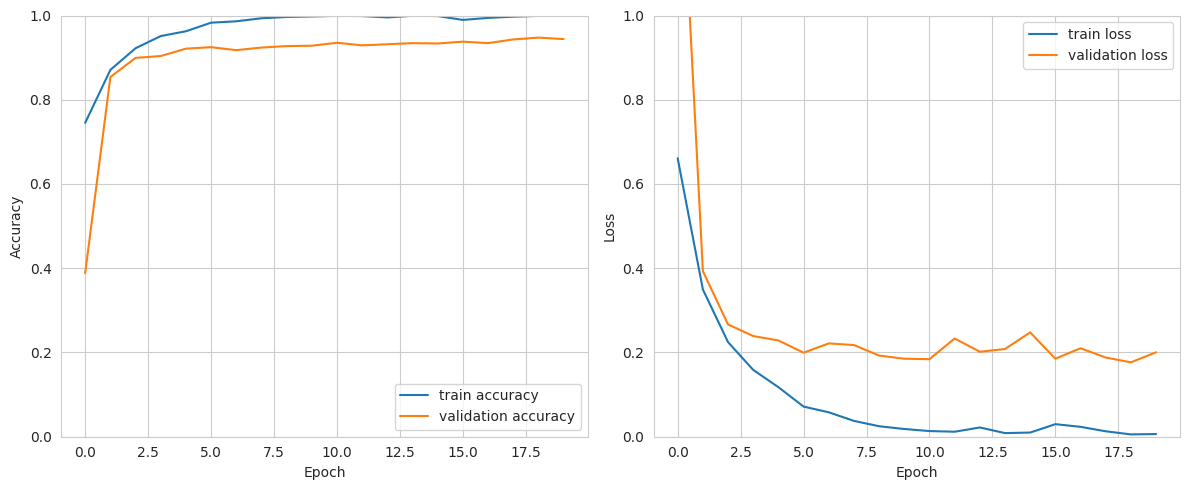

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['accuracy'], label='train accuracy')
ax1.plot(history.history['val_accuracy'], label='validation accuracy')
ax1.grid(True)
ax1.legend(loc='lower right')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylim([0, 1])

ax2.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['val_loss'], label='validation loss')
ax2.grid(True)
ax2.legend(loc='upper right')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

In [15]:
test = pd.read_csv(f'{BASE_PATH}/testing_data.csv', sep=";")
test_images = [preprocessing_image(f"{BASE_PATH}/{image}", size, normalize=True) for image in test['path']]
test_labels = test['class'].values
class_names = train['class_name'].unique()

In [16]:
test_loss, test_accuracy = model.evaluate(np.array(test_images), np.array(test_labels))
print(f"Test accuracy: {test_accuracy}")

41/41 [==============================] - 1s 10ms/step - loss: 0.1699 - accuracy: 0.9458
Test accuracy: 0.9458428621292114


In [17]:
y_pred = model.predict(np.array(test_images))
y_pred = np.argmax(y_pred, axis=1)

y_true = test_labels

conf_matrix = confusion_matrix(y_true, y_pred)

class_report = classification_report(y_true, y_pred, target_names=class_names)

print(class_report)


41/41 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

   pituitary       0.94      0.91      0.93       300
      glioma       0.89      0.90      0.89       306
  meningioma       0.98      0.98      0.98       405
     notumor       0.96      0.98      0.97       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



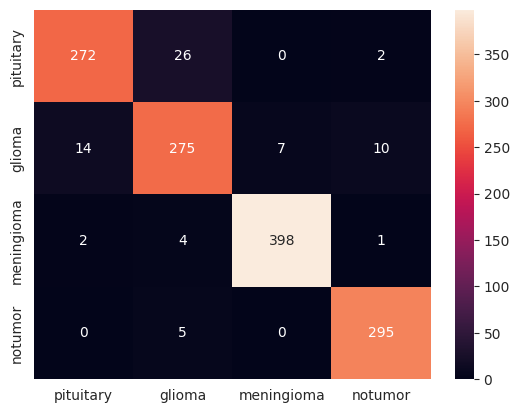

In [18]:
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.show()